In [66]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from pylab import cm

import os
from collections import OrderedDict
from adjustText import adjust_text

%matplotlib inline
%config InlineBackend.figure_format='svg'
# Edit the font, font size, and axes width
mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2

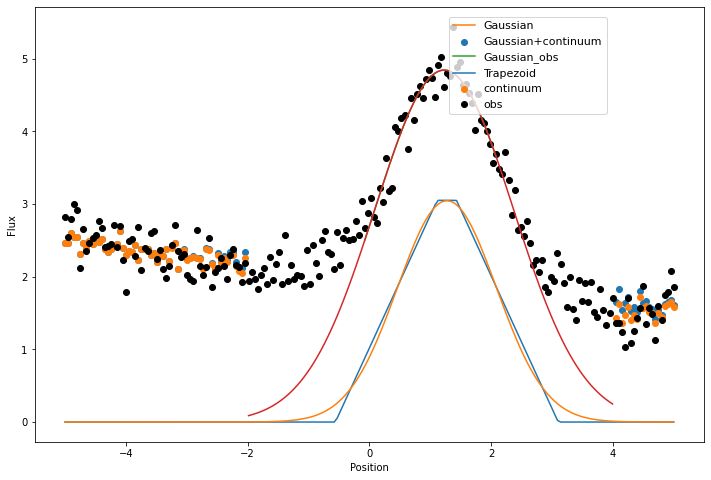

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from collections import OrderedDict

# Generate fake data
np.random.seed(0)
x = np.linspace(-5., 5., 200)
y = 3 * np.exp(-0.5 * (x - 1.3)**2 / 0.8**2)
y += np.random.normal(0., 0.2, x.shape)

continuum= 2.0-0.1*x+np.random.normal(0., 0.1, x.shape)
yobs=y+continuum

z_min,z_max=-0.1,2.1
z_mask = np.logical_and(x >= z_min, x < z_max)

#z_min,z_max=-0.1,2.1
z_mask_or = np.logical_or(x < z_min, x > z_max)
continuum_or=continuum[z_mask_or]
ybos_fit_or=yobs[z_mask_or]

x_fit=x[z_mask]
yobs_fit=yobs[z_mask]
continuum_fit=continuum[z_mask]

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Trapezoid1D(amplitude=1., x_0=0., width=1., slope=0.5,
                            bounds={"x_0": (-5., 5.)})
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y)

# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y)

g_init_obs = models.Gaussian1D(amplitude=3., mean=1.3, stddev=1.,
                              bounds={"mean": (0, 2.0)})
fit_g_obs = fitting.LevMarLSQFitter()
g_obs = fit_g_obs(g_init_obs, x_fit, yobs_fit)


# Plot the data with the best-fit model
#plt.figure(figsize=(8,5))
#plt.plot(x, y, 'ko')
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(hspace=0.0, wspace = 0.0)
ax = fig.add_subplot(111)

plt.plot(x, yobs, 'ko',label='obs')
plt.plot(x, t(x), label='Trapezoid')

plt.plot(x, g(x), label='Gaussian')
plt.plot(x[z_mask], g_obs(x)[z_mask], label='Gaussian_obs')

z_min_fit,z_max_fit=-2,4
z_mask_fit = np.logical_and(x >= z_min_fit, x <= z_max_fit)
z_mask_fit_or = np.logical_or(x < z_min_fit, x > z_max_fit)

plt.plot(x[z_mask_fit], g_obs(x)[z_mask_fit], label='Gaussian+continuum')
plt.scatter(x[z_mask_fit_or], g_obs(x)[z_mask_fit_or]+continuum[z_mask_fit_or], label='Gaussian+continuum')
plt.scatter(x[z_mask_fit_or], continuum[z_mask_fit_or], label='continuum')


plt.xlabel('Position')
plt.ylabel('Flux')
#plt.legend(loc=2)

    
    
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
#hdl = [h[0] for h in handles]
hdl=handles
labels_dict=dict(zip(labels, hdl)) #key,values
by_label=OrderedDict(sorted(labels_dict.items(),key=lambda t:t[0]))#根据key排序
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(0.61, 0.99),
          loc=2, numpoints=1,ncol=1,fontsize=11.)


In [16]:
g

<Gaussian1D(amplitude=3.04705247, mean=1.27430146, stddev=0.81353503)>

In [17]:
g_obs 

<Gaussian1D(amplitude=4.84474465, mean=1.22878767, stddev=1.13508347)>

In [25]:
1.27430146/0.81353503

1.5663756482618825

In [26]:
from scipy.integrate import quad 

print(g.mean.value,g.stddev.value)
I_quad, est_err_quad = quad(g, g.mean.value-g.stddev.value, g.mean.value+g.stddev.value)
print(I_quad, est_err_quad)

1.2743014580861238 0.8135350264067557
4.241987077196352 4.709551723265762e-14


In [28]:
def continuum(x):
    return 2.0-0.1*x

In [29]:
print(g_obs.mean.value,g_obs.stddev.value)
I_quad, est_err_quad = quad(g_obs, g_obs.mean.value-g.stddev.value, g_obs.mean.value+g.stddev.value)
print(I_quad, est_err_quad)

I_quad_continum, est_err_quad_continum = quad(continuum, g_obs.mean.value-g.stddev.value, g_obs.mean.value+g.stddev.value)
print(I_quad_continum, est_err_quad_continum)


1.2287876734941527 1.1350834718280567
7.2568380351796264 8.056708672632002e-14
3.0542077431461507 3.390851758429293e-14


In [30]:
I_quad-I_quad_continum

4.202630292033476

In [38]:
import numpy as np
from astropy.modeling import Fittable1DModel, Parameter
from astropy.modeling.models import Linear1D


class LineModel(Fittable1DModel):
    slope = Parameter()
    intercept = Parameter()
    linear = True

    @staticmethod
    def evaluate(x, slope, intercept):
        return slope * x + intercept

    @staticmethod
    def fit_deriv(x, slope, intercept):
        d_slope = x
        d_intercept = np.ones_like(x)
        return [d_slope, d_intercept]

    @property
    def inverse(self):
        new_slope = self.slope ** -1
        new_intercept = -self.intercept / self.slope
        return LineModel(slope=new_slope, intercept=new_intercept)

In [39]:
Linear1D

<class 'astropy.modeling.functional_models.Linear1D'>
Name: Linear1D
N_inputs: 1
N_outputs: 1
Fittable parameters: ('slope', 'intercept')

In [41]:
from astropy.modeling import models

gauss1 = models.Gaussian1D(amplitude=3., mean=1.3, stddev=1.,
                              bounds={"mean": (0, 2.0)})

#linear1 = LineModel(slope=-0.1, intercept=2.0)
linear1 = Linear1D(slope=-0.1, intercept=2.0,
                 bounds={"slope": (-1.0, 1.0)}
                )

func_combine=gauss1+linear1

fit_g_combine = fitting.LevMarLSQFitter()
g_combine  = fit_g_combine(func_combine, x_fit, yobs_fit)




In [42]:
g_combine

<CompoundModel(amplitude_0=3.29092499, mean_0=1.27122039, stddev_0=0.84516614, slope_1=-0.11108722, intercept_1=1.74817641)>

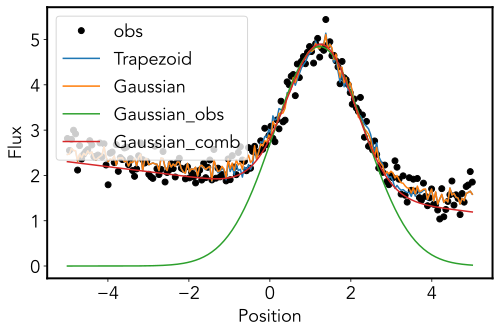

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting

# Generate fake data
np.random.seed(0)
x = np.linspace(-5., 5., 200)
y = 3 * np.exp(-0.5 * (x - 1.3)**2 / 0.8**2)
y += np.random.normal(0., 0.2, x.shape)

continuum= 2.0-0.1*x+np.random.normal(0., 0.1, x.shape)
yobs=y+continuum

z_min,z_max=-0.1,2.1
z_mask = np.logical_and(x >= z_min, x < z_max)
x_fit=x[z_mask]
yobs_fit=yobs[z_mask]


# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Trapezoid1D(amplitude=1., x_0=0., width=1., slope=0.5,
                            bounds={"x_0": (-5., 5.)})
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y)

# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y)

g_init_obs = models.Gaussian1D(amplitude=3., mean=1.3, stddev=1.,
                              bounds={"mean": (0, 2.0)})
fit_g_obs = fitting.LevMarLSQFitter()
g_obs = fit_g_obs(g_init_obs, x_fit, yobs_fit)


# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
#plt.plot(x, y, 'ko')

plt.plot(x, yobs, 'ko',label='obs')
plt.plot(x, t(x)+continuum, label='Trapezoid')
plt.plot(x, g(x)+continuum, label='Gaussian')

plt.plot(x, g_obs(x), label='Gaussian_obs')
plt.plot(x, g_combine(x), label='Gaussian_comb')


plt.xlabel('Position')
plt.ylabel('Flux')
plt.legend(loc=2)

In [70]:
github_root_url='https://github.com'
nbviewer_root_url='https://nbviewer.org/github'
github_url='https://github.com/QiaoyaWu/sdss4_dr16q_tutorial/blob/main/op/5808-56325-0560.pdf'
nbviewer_url='https://nbviewer.org/github/QiaoyaWu/sdss4_dr16q_tutorial/blob/main/op/5808-56325-0560.pdf'

In [97]:
theta = np.linspace(0, 2 * np.pi, num=1000, endpoint=True)

print(np.trapz(np.cos(theta), x=np.sin(theta)))

print(np.trapz(np.cos(theta)))

print(np.trapz(np.cos(theta), x=theta))

3.141571941375841
-1.1368683772161603e-13
-1.1102230246251565e-16


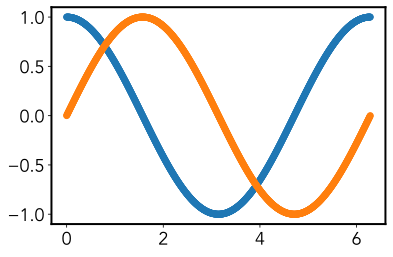

In [98]:
plt.scatter(theta,np.cos(theta))
plt.scatter(theta,np.sin(theta))

In [79]:
#np.sin(theta),np.trapz(np.cos(theta))

In [73]:
from IPython.display import IFrame
IFrame(nbviewer_url, width=800, height=450)

In [108]:
luorui_cv_pdf='https://github.com/RuiLuoAstro/RuiLuoAstro.github.io/blob/master/cv/cv_ruiluo.pdf'
nb_luorui_cv_pdf= 'https://nbviewer.org/github/'+'RuiLuoAstro/RuiLuoAstro.github.io/blob/master/cv/cv_ruiluo.pdf'
    
from IPython.display import IFrame
IFrame(nb_luorui_cv_pdf, width=850, height=550)